## Scenario-based hazard analysis

**Raul Rincon, Dept. of Civil and Environmental Engineering, Rice University**<br>
**Jamie Ellen Padgett, Dept. of Civil and Environmental Engineering, Rice University**<br>


A simple example on different functionalities of the module for hazard analyses.

In [1]:
import numpy as np
import geopandas as gpd
from matplotlib import pyplot as plt
import os

First a quick review of the data is presented. The data is retrieved from Rincon and Padgett (2023).

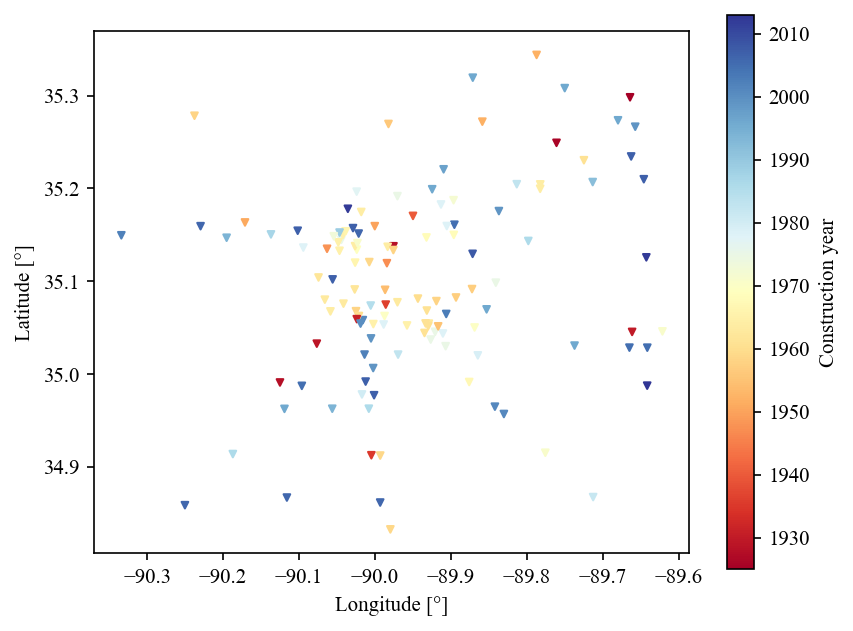

In [28]:
# Exposure information has been retrieved from DesignSafe PRJ 3939 (Rincon and Padgett, 2023) and saved in /fromPRJ3939
route_to_published_projec = './fromPRJ3939/'
name_shapefile_bridges = 'MMSA_centroid_bridges_intermediate.shp'
name_shapefile_road_network = 'MMSA_Network_intermediate.shp'

# Shapefiles for visualization from PRJ 3939
bridges_network = gpd.read_file(os.path.join(route_to_published_projec,name_shapefile_bridges))

# Plot shapefiles data in a map.
fig, ax = plt.subplots(1, 1, dpi=150)
bridges_network.plot(column=bridges_network.YEAR_BUILT, # select the attribute to highight
                  cmap='RdYlBu', # select a colormap
                  ax=ax, zorder=1, s = 10, marker="v",legend=True, 
                  legend_kwds={'label': "Construction year",'orientation': "vertical"}) # define colorbar name and orientation
plt.xlabel('Longitude [°]')
plt.ylabel('Latitude [°]')
plt.show()

The function `compute_seismic_im` returns two lists, one correspons to the outputs of the itensity measures of the assests (noted as `im_per_event_pga`) and the second one  correspons to a user-defined points of interest, e.g., a mesh (noted as `im_per_event_meshgrid`).

## Estimation of intensity mesures - Example

### Median intensity values

Let's assume a set of model parameters for a point source event: 
- M_w = [5,8]
- Location = 35.927 N, 89.919W
- Only median estimate (no residuals)
- Bedrock

In [46]:
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from src import ground_motion_models as gmm

start_point = (35.927, -89.919)

minMw = 5
maxMw = 8
stepMw = 0.5

Mw = np.arange(minMw, maxMw+stepMw, stepMw).reshape(-1, 1)
num_simulated_residuals = 3

# Scenario analysis - Consider specifc values of event magnitudes
# Define the boundaries for maps
lat_min = np.min(bridges_network.bounds['miny'])*.9995
lat_max = np.max(bridges_network.bounds['maxy'])*1.0005
lon_min = np.min(bridges_network.bounds['minx'])*1.0005
lon_max = np.max(bridges_network.bounds['maxx'])*0.9995

# Create the mesh for estimating the hazard
y = np.linspace(lat_min, lat_max, 40)
x = np.linspace(lon_min, lon_max, 40)
simul_residuals_per_event = num_simulated_residuals
seed_hazard = 12345
Xm, Ym = np.meshgrid(x, y)

X = Xm.reshape(-1,)
Y = Ym.reshape(-1,)
# # Hazard evaluation - Here the hazard is evaluated on a grid for visualization purposes
# First, lets analyze the scenario which location is the start point:
im_per_event_pga, im_per_event_meshgrid = gmm.compute_seismic_im(
    bridges_network.Latitude,
    bridges_network.Longitude,
    start_point[0],
    start_point[1],
    Mw, type_ims='pga',
    meshY=Y, meshX=X,
    fundamental_period=None,
    soil_type='bedrock',  # bedrock #deep-soil
    simul_residuals_per_event=simul_residuals_per_event,
    soil_variation='no clusters', # 'clusters' 'no clusters'
    include_residuals=False,
    same_residuals_for_magnitudes=True,
    seed=seed_hazard)

Calculating location in cartesian units
Calculating distances between points
Calculating the covariance matrix
Computing the simulations of intensity measures per event


100%|██████████| 7/7 [00:00<00:00, 1747.83it/s]


The magnitude to be plotted is:  [8.]


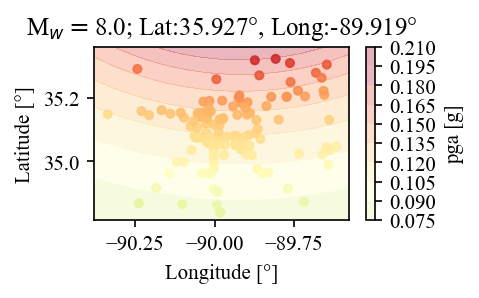

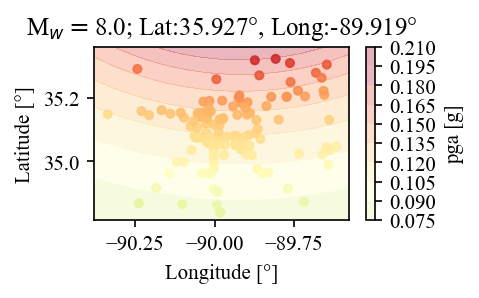

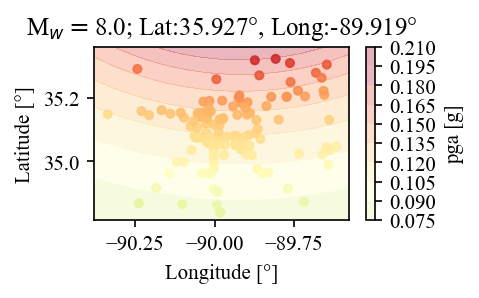

In [48]:
# %% Plotting the seismic events (hazard intensity for a mesh of points and assets)
event_mw_i = -1
print("The magnitude to be plotted is: ",str(Mw[event_mw_i]))

for resid_plot in range(num_simulated_residuals):
    fig, ax = plt.subplots(1, 1, figsize=(3, 1.5), dpi=150)
    plt.contourf(Xm, Ym, im_per_event_meshgrid[event_mw_i][resid_plot, :].reshape(len(Ym), len(Ym)),
                    alpha=0.3, cmap='RdYlGn_r',
                    vmin=0, vmax=np.max(im_per_event_meshgrid[event_mw_i][resid_plot, :]),
                    )

    cbar = plt.colorbar()
    cbar.set_label('pga [g]')
    plt.gca().set_aspect('equal', 'box')
    ax.set_xlim([lon_min, lon_max])
    ax.set_ylim([lat_min, lat_max])
    ax.set_title('M$_w = $'+str(round(Mw[event_mw_i, 0], 1)) +
                    '; Lat:'+str(round(start_point[0], 3)) +
                    '°, Long:'+str(round(start_point[1], 3))+'°')
    sc = ax.scatter(bridges_network.Longitude, bridges_network.Latitude,
                    c=im_per_event_pga[event_mw_i][resid_plot, :], s=15, alpha=0.85,
                    cmap='RdYlGn_r',
                    vmin=0, vmax=np.max(im_per_event_meshgrid[event_mw_i][resid_plot, :]),
                    )

    # plt.colorbar(sc)
    limits = plt.axis('on')  # turns on axis
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    plt.xlabel('Longitude [°]')
    plt.ylabel('Latitude [°]')

The three plots are the same!

### Median intensity values including correlated ground motion intra-event residuals

Let's assume a set of model parameters for a point source event: 
- M_w = [5,8]
- Location = 35.927 N, 89.919W
- Soil type "bedrock", and soil-effects "not showing clusters (i.e., Case 1 in JB08)".

Calculating location in cartesian units
Calculating distances between points
Calculating the covariance matrix
Computing the simulations of intensity measures per event


100%|██████████| 7/7 [00:00<00:00, 1398.30it/s]


The magnitude to be plotted is:  [8.]


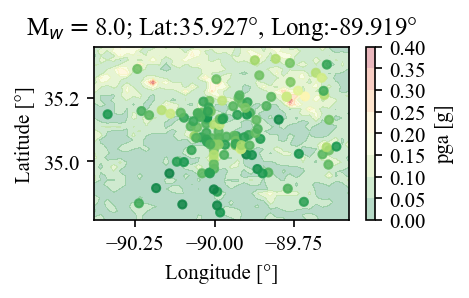

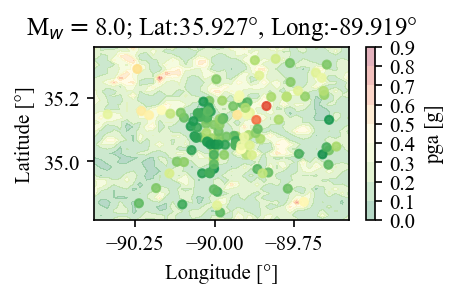

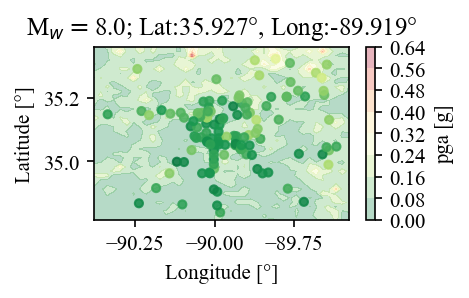

In [50]:
# # Hazard evaluation - Here the hazard is evaluated on a grid for visualization purposes
# First, lets analyze the scenario which location is the start point:
im_per_event_pga, im_per_event_meshgrid = gmm.compute_seismic_im(
    bridges_network.Latitude,
    bridges_network.Longitude,
    start_point[0],
    start_point[1],
    Mw, type_ims='pga',
    meshY=Y, meshX=X,
    fundamental_period=None,
    soil_type='bedrock',  # bedrock #deep-soil
    simul_residuals_per_event=simul_residuals_per_event,
    soil_variation='no clusters',
    include_residuals=True,
    same_residuals_for_magnitudes=True,
    seed=seed_hazard)

event_mw_i = -1
print("The magnitude to be plotted is: ",str(Mw[event_mw_i]))

for resid_plot in range(num_simulated_residuals):
    fig, ax = plt.subplots(1, 1, figsize=(3, 1.5), dpi=150)
    plt.contourf(Xm, Ym, im_per_event_meshgrid[event_mw_i][resid_plot, :].reshape(len(Ym), len(Ym)),
                    alpha=0.3, cmap='RdYlGn_r',
                    vmin=0, vmax=np.max(im_per_event_meshgrid[event_mw_i][resid_plot, :]),
                    )

    cbar = plt.colorbar()
    cbar.set_label('pga [g]')
    plt.gca().set_aspect('equal', 'box')
    ax.set_xlim([lon_min, lon_max])
    ax.set_ylim([lat_min, lat_max])
    ax.set_title('M$_w = $'+str(round(Mw[event_mw_i, 0], 1)) +
                    '; Lat:'+str(round(start_point[0], 3)) +
                    '°, Long:'+str(round(start_point[1], 3))+'°')
    sc = ax.scatter(bridges_network.Longitude, bridges_network.Latitude,
                    c=im_per_event_pga[event_mw_i][resid_plot, :], s=15, alpha=0.85,
                    cmap='RdYlGn_r',
                    vmin=0, vmax=np.max(im_per_event_meshgrid[event_mw_i][resid_plot, :]),
                    )

    # plt.colorbar(sc)
    limits = plt.axis('on')  # turns on axis
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    plt.xlabel('Longitude [°]')
    plt.ylabel('Latitude [°]')
    plt.show()

Now let's change some parameters:
- Soil type "deep-soil", and soil-effects "showing clusters".

Calculating location in cartesian units
Calculating distances between points
Calculating the covariance matrix
Computing the simulations of intensity measures per event


100%|██████████| 7/7 [00:00<00:00, 1650.09it/s]

The magnitude to be plotted is:  [8.]


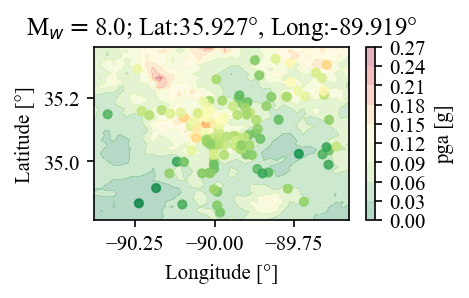

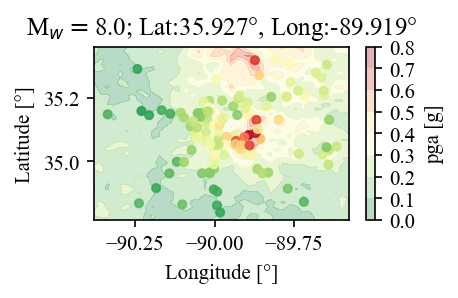

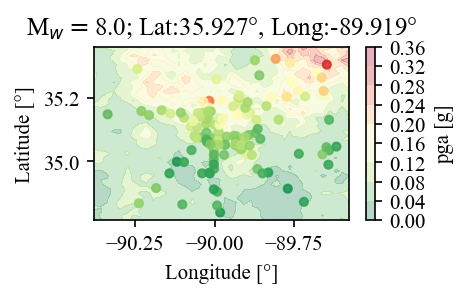

In [51]:
# # Hazard evaluation - Here the hazard is evaluated on a grid for visualization purposes
# First, lets analyze the scenario which location is the start point:
im_per_event_pga, im_per_event_meshgrid = gmm.compute_seismic_im(
    bridges_network.Latitude,
    bridges_network.Longitude,
    start_point[0],
    start_point[1],
    Mw, type_ims='pga',
    meshY=Y, meshX=X,
    fundamental_period=None,
    soil_type='deep-soil',  # bedrock #deep-soil
    simul_residuals_per_event=simul_residuals_per_event,
    soil_variation='clusters',
    include_residuals=True,
    same_residuals_for_magnitudes=True,
    seed=seed_hazard)

event_mw_i = -1
print("The magnitude to be plotted is: ",str(Mw[event_mw_i]))

for resid_plot in range(num_simulated_residuals):
    fig, ax = plt.subplots(1, 1, figsize=(3, 1.5), dpi=150)
    plt.contourf(Xm, Ym, im_per_event_meshgrid[event_mw_i][resid_plot, :].reshape(len(Ym), len(Ym)),
                    alpha=0.3, cmap='RdYlGn_r',
                    vmin=0, vmax=np.max(im_per_event_meshgrid[event_mw_i][resid_plot, :]),
                    )

    cbar = plt.colorbar()
    cbar.set_label('pga [g]')
    plt.gca().set_aspect('equal', 'box')
    ax.set_xlim([lon_min, lon_max])
    ax.set_ylim([lat_min, lat_max])
    ax.set_title('M$_w = $'+str(round(Mw[event_mw_i, 0], 1)) +
                    '; Lat:'+str(round(start_point[0], 3)) +
                    '°, Long:'+str(round(start_point[1], 3))+'°')
    sc = ax.scatter(bridges_network.Longitude, bridges_network.Latitude,
                    c=im_per_event_pga[event_mw_i][resid_plot, :], s=15, alpha=0.85,
                    cmap='RdYlGn_r',
                    vmin=0, vmax=np.max(im_per_event_meshgrid[event_mw_i][resid_plot, :]),
                    )

    # plt.colorbar(sc)
    limits = plt.axis('on')  # turns on axis
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    plt.xlabel('Longitude [°]')
    plt.ylabel('Latitude [°]')
    plt.show()

### Structure of the outputs:

The `im_per_event_pga` is a list of `numpy.arrays`. The len of the list corresponds to the total number of magnitudes assessed. Each element of the list contains the $n_{maps}$ hazard maps with the correlated or not intensity measures for the total $n_{bridges}$. That is, each map's shape (numpy.array) is $n_{maps} \times n_{bridges}$.

In [56]:
print('Total of magnitudes is ',len(im_per_event_pga))
print('Total of maps is ',im_per_event_pga[0].shape[0])
print('Total of bridges is ',im_per_event_pga[0].shape[1])

Total of magnitudes is  7
Total of maps is  3
Total of bridges is  130


## References
* Rincon, R., J. Padgett (2023). "Jupyter notebook for visualization of spatially distributed data in risk and resilience analysis", in Jupyter notebook for visualization of spatially distributed data in risk and resilience analysis. DesignSafe-CI. https://doi.org/10.17603/ds2-a74m-g031
* Jayaram N and Baker JW (2009) Correlation model for spatially distributed ground-motion intensities. Earthquake Engineering & Structural Dynamics 38(15): 1687–1708. [10.1002/eqe.922](https://doi.org/10.1002/eqe.922). [ Link](https://www.jackwbaker.com/Publications/Jayaram_Baker_(2009)_spatial_correlation,_EESD.pdf)
* Atkinson GM and Boore DM (1995) Ground-motion relations for eastern North America. Bulletin of the Seismological Society of America, 85(1): 17–30. [DOI: 10.1785/BSSA0850010017](https://doi.org/10.1785/BSSA0850010017)